# **Imbalance Classification with Credit Fraud Dataset**

In this notebook, we will study how classification should be done on unbalanced dataset.
* What is Unbalanced Data?
* With which models are unbalanced data trained?
* Which evaluation metric is correct to use in Unbalanced Data?

We will seek answers to these questions.

## Imbalanced Data

The number of examples that belong to each class may be referred to as the class distribution.

Imbalanced classification refers to a classification predictive modeling problem where the number of examples in the training dataset for each class label is not balanced. That is, where the class distribution is not equal or close to equal, and is instead biased or skewed. 

The abundance of examples from the majority class (or classes) can swamp the minority class. Most machine learning algorithms for classification predictive models are designed and demonstrated on problems that assume an equal distribution of classes. This means that a naive application of a model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class that is, in fact, of more interest and whose predictions are more valuable.

Ps: The class or classes with abundant examples are called the major or majority classes, whereas the class with few examples (and there is typically just one) is called the minor or minority class.

Many classification problems may have a severe imbalance in the class distribution. Some of those;
* Fraud Detection.
* Claim Prediction
* Default Prediction.
* Churn Prediction.
* Spam Detection.
* Anomaly Detection.
* Outlier Detection.
* Intrusion Detection
* Conversion Prediction.

## 1.Data Exploration

The problem we chose to examine the imbalanced classification in this notebook was credit card fraud. We will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. 

In [ ]:
try:
  import warnings

  import numpy as np
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
  from sklearn.model_selection import train_test_split, StratifiedKFold
  from sklearn.preprocessing import RobustScaler

  from xgboost import XGBClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


  print("Libraries imported.")
except:
  print("Failed to import libraries!!")

Libraries imported.


In [ ]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (8, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time -> Number of seconds elapsed between this transaction and the first transaction in the dataset.

(V1-V28) -> may be result of a PCA Dimensionality reduction to protect user identities and sensitive features.

Amount -> Transaction amount

Class -> 1 for fraudulent transactions, 0 otherwise

**As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons.**

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
print("Count of Missing Value is: "+ str(df.isna().sum().max()))

Count of Missing Value is: 0


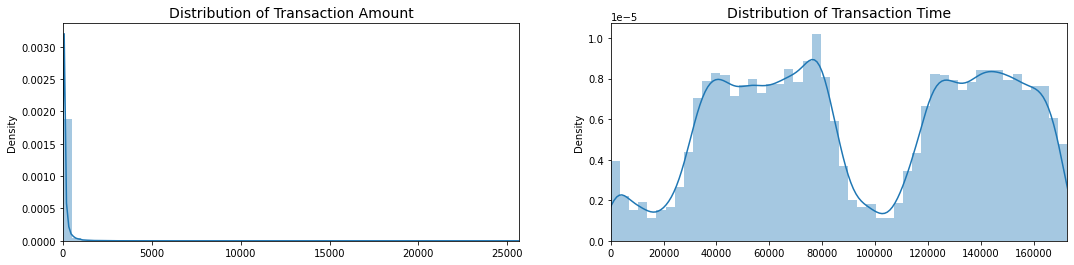

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(df.Amount.values), max(df.Amount.values)])

sns.distplot(time_val, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(df.Time.values), max(df.Time.values)])



plt.show()

Text(0.5, 1.0, 'Class Value Count')

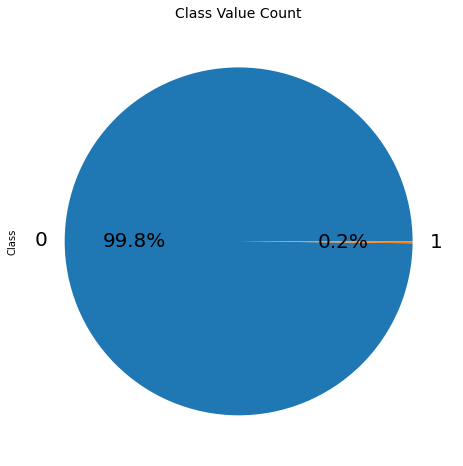

In [ ]:
df.Class.value_counts().plot.pie(autopct="%.1f%%",fontsize=20)
plt.title("Class Value Count", fontsize=14)

## 2.Data Preprocessing

Amount of the Credit Card Fraud dataset have very different scales and contain some very large outliers. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.

# 2.1.Scaling

The centering and scaling statistics of RobustScaler is based on percentiles and are therefore not influenced by a few number of very large marginal outliers. 

In [ ]:
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

# 2.2.Split Data

Before proceeding with the Re-Sampling techniques we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing Re-Sampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [ ]:
df_copy = df.copy()

y = df_copy.pop('Class')
X = df_copy

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [ ]:
print(Xtrain.shape)
print(Xtest.shape)

(227846, 30)
(56961, 30)


In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
119934,-1.010514,1.046555,0.976703,-1.685199,-0.393491,-1.728835,0.774116,0.130066,0.343159,-1.792082,-0.049408,1.388713,0.816125,0.229849,-0.087022,-1.026666,0.215289,-0.506211,0.022602,-0.032424,0.063292,0.344471,-0.348916,0.969378,1.097208,-0.648502,0.110193,-0.038529,0,-0.150632,-0.106357
239501,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,-0.448794,-2.562602,0.243483,-1.181669,0.004373,-2.302596,-4.446192,-1.710463,0.982729,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,1,3.007895,0.768888
69265,-0.986359,-0.986568,0.810163,-2.295833,-0.119063,-0.291529,-1.057358,0.453522,-2.002365,0.352957,-2.399792,-0.569409,1.583207,-0.866187,-1.531980,-0.260477,0.293973,0.163664,-0.061673,-0.185592,-0.170995,-0.305573,-0.366794,-0.977288,0.561127,-0.181472,-0.066971,-0.196170,0,-0.265353,-0.368296
204079,1.862102,-0.124052,-1.989752,0.382609,0.473032,-0.674517,0.298621,-0.282416,0.802053,-0.989431,-0.491112,0.903819,1.366524,-1.886162,-0.194861,0.086837,0.978546,0.055604,0.189131,0.150727,-0.204158,-0.511441,0.077874,0.388335,0.007896,-0.120980,-0.019579,0.006155,1,1.208831,0.592230
15476,-21.209120,12.652197,-23.553933,6.174078,-16.026658,-4.422195,-16.229444,14.116002,-3.922741,-8.720245,5.493887,-7.740816,0.384814,-8.078241,-0.014900,-6.701289,-13.159267,-4.903031,1.146275,1.602439,1.758440,-1.522588,-0.903860,0.130166,1.454857,-0.223214,1.550928,0.461460,1,1.089779,-0.679390


In [ ]:
new_df.shape

(984, 31)

Text(0.5, 1.0, 'Class Value Count')

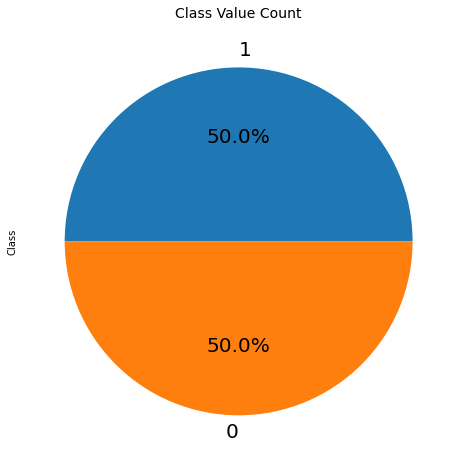

In [ ]:
new_df.Class.value_counts().plot.pie(autopct="%.1f%%",fontsize=20)
plt.title("Class Value Count", fontsize=14)

In [ ]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.95%


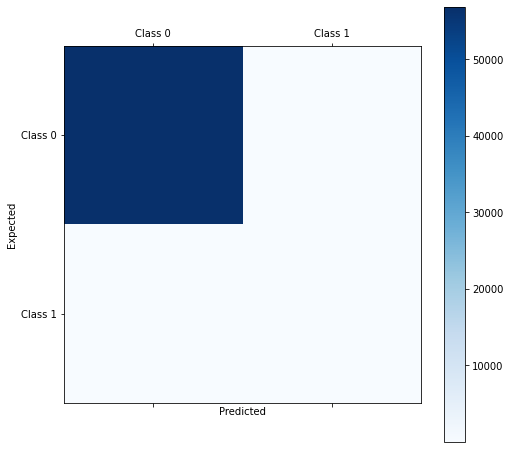

In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
sns.jointplot(df[]['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [ ]:
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

In [ ]:
pos_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,-2.032638,-2.732792,3.274075,-3.541687,-0.946820,-7.555729,-1.767005,-0.642333,-2.114429,0.183327,-1.177793,0.163513,0.289861,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,-0.293440,0.689176
1,-10.527304,7.639745,-13.443115,4.303403,-8.048210,-3.466997,-8.643193,7.284105,-2.362097,-5.996596,2.589104,-5.962261,-0.468955,-6.778184,0.907947,-3.970130,-6.857613,-2.511736,0.511762,0.847085,0.937416,-0.931178,-0.235697,-0.031393,0.591558,-0.263516,1.108897,0.219021,1.089779,-0.394236
2,1.083693,1.179501,-1.346150,1.998824,0.818034,-0.771419,0.230307,0.093683,-0.167594,-1.959809,2.804335,0.312424,-0.595976,-4.662577,-0.299515,1.001414,3.902825,1.619609,-0.888087,-0.060159,-0.312000,-0.639700,-0.120249,-0.180218,0.609283,-0.339524,0.096701,0.114972,-0.293440,-0.524043
3,-2.019001,1.491270,0.005222,0.817253,0.973252,-0.639268,-0.974073,-3.146929,-0.003159,-0.121653,0.024370,-1.073812,-2.002769,-0.895434,1.748936,-0.103527,2.031196,0.317598,0.386761,-1.029965,2.839596,-1.185443,-0.142812,-0.086103,-0.329113,0.523601,0.626283,0.152440,-0.296793,-0.576922
4,-3.951209,2.881805,-6.421490,2.434181,-1.327325,-2.122106,-3.227533,-0.685560,0.775985,-4.723092,4.921657,-8.752770,1.520198,-8.552023,0.351976,-4.534030,-6.465409,-1.890310,0.174840,-0.669351,1.410479,0.279403,0.570821,0.656271,-0.298601,-0.407571,-1.378703,1.379130,0.428841,0.078890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,-11.205461,7.914633,-13.987752,4.333341,-8.484970,-3.506561,-8.935243,7.704449,-2.336584,-5.927359,2.470401,-5.788517,-0.391939,-6.527462,0.899859,-3.847293,-6.700637,-2.492616,0.469554,0.860912,0.942593,-0.987848,-0.279446,-0.027299,0.644344,-0.263078,1.084023,0.211933,1.089779,-0.394001
302,-25.942434,14.601998,-27.368650,6.378395,-19.104033,-4.684806,-18.261393,17.052566,-3.742605,-8.233721,4.664836,-6.525668,0.923759,-6.325975,-0.070224,-5.838360,-12.061696,-4.773349,0.852970,1.667304,1.784316,-1.917759,-1.235787,0.161105,1.820378,-0.219359,1.388786,0.406810,1.089779,-0.674820
303,-0.234922,0.355413,1.972183,-1.255593,-0.681387,-0.665732,0.059110,-0.003153,1.122451,-1.481246,-0.473852,0.922184,0.913514,-0.499350,0.933898,-0.560472,-0.207707,0.380542,0.574336,-0.003469,0.220670,0.912107,-0.286338,0.451208,0.188315,-0.531846,0.123185,0.039581,-0.293440,-0.471810
304,-2.349340,1.512604,-2.647497,1.753792,0.406328,-2.188494,-0.686935,-0.547984,-0.099528,-1.672346,2.172976,-3.103477,0.217561,-6.034403,0.164401,-2.383826,-4.166479,-1.772397,-0.526281,-0.093421,-0.088519,-0.595178,0.258148,0.061901,-0.354180,-1.152671,-0.736073,0.733703,-0.238944,0.885137


## 3.Re-Sampling

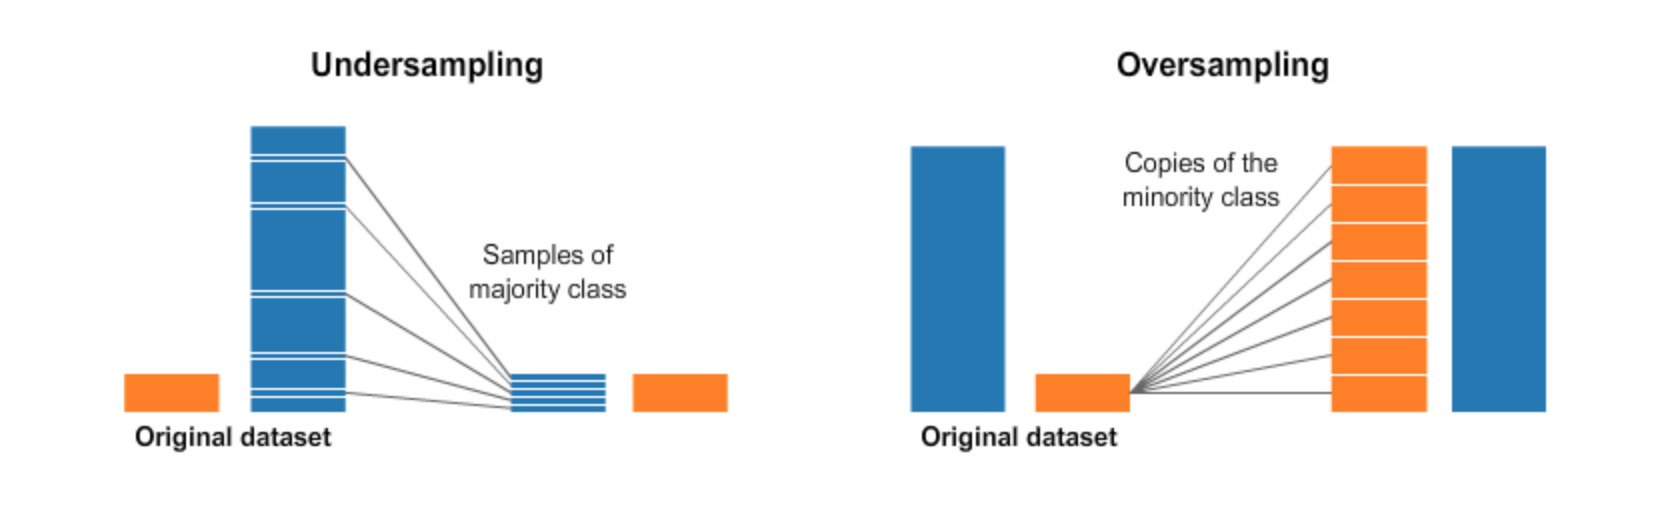

In [ ]:
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [ ]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

In [ ]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",XGBClassifier(random_state=SEED))]

In [ ]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [ ]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

## REFERENCE

* https://machinelearningmastery.com/what-is-imbalanced-classification/
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* https://www.kaggle.com/qianchao/smote-with-imbalance-data
* https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
* https://www.kaggle.com/imsanjoykb/data-visualization-tutorial-matplotlib-seaborn